# A Physics-Informed Neural Network approach for compartmental epidemiological models


Notebooks for PINN solution of the SIR compartmental model presented [in the paper](https://arxiv.org/abs/2311.09944):

```
@misc{millevoi2023physicsinformed,
      title={A Physics-Informed Neural Network approach for compartmental epidemiological models}, 
      author={Caterina Millevoi and Damiano Pasetto and Massimiliano Ferronato},
      year={2023},
      eprint={2311.09944},
      archivePrefix={arXiv},
      primaryClass={math.NA}
}
```

Note: The uploaded code is related to Case 1. For further information please contact the corresponding author.

In [1]:
import sciann as sn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.integrate import odeint

2024-05-19 15:34:01.706228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 15:34:02.228874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-19 15:34:02.228931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-19 15:34:02.228938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.9.18 (main, Jan 24 2024, 00:00:00) 
[GCC 11.4.1 20231218 (Red Hat 11.4.1-3)] 



## Case 1: constant trasmission rate

In [2]:
# SIR parameters
N     = 56e6 # (-) population (Italy)
delta = 1/5  # (1/T) 5 = mean reproduction period 
r0    = 3.   # (-) basic reproduction number (estimate for Italy) 

beta = delta*r0 # (1/T) transmission rate 
t0   = 0.       # (days) initial time
tf = 90.        # (days) final time

C = 1e5
C1 = tf*C/N   
C2 = tf*delta

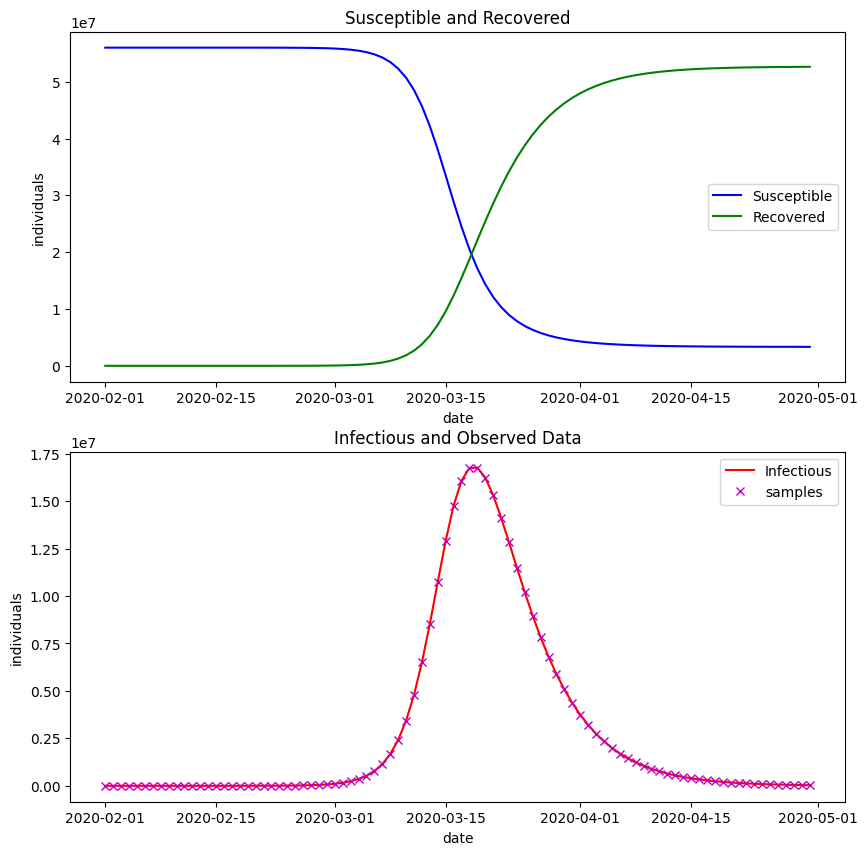

In [3]:
# Function to define the SIR model
def SIR(x, t, delta, beta, N, t0):
    S, I, R = x
    lambda_val = beta*I/N;
    dSdt = -lambda_val*S
    dIdt = lambda_val*S - delta*I
    dRdt = delta*I
    return [dSdt, dIdt, dRdt]

# Initial conditions
S0 = N-1
I0 = 1
R0 = 0
x0 = [S0, I0, R0]

# Time span
timespan = np.arange('2020-02-01', '2020-05-01', dtype='datetime64[D]')
tspan = timespan.astype(int)

# Solve the ODE
x = odeint(SIR, x0, tspan, args=(delta, beta, N, tspan[0]))

S_data = x[:, 0]
I_data = x[:, 1]
R_data = x[:, 2]

# Generate observations
I_obs = np.random.poisson(I_data)

# Plot results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(timespan, S_data, 'b', label='Susceptible')
plt.plot(timespan, R_data, 'g', label='Recovered')
plt.legend()
plt.xlabel('date')
plt.ylabel('individuals')
plt.title('Susceptible and Recovered')
plt.subplot(2, 1, 2)
plt.plot(timespan, I_data, 'r', label='Infectious')
plt.plot(timespan, I_obs, 'xm', label='samples')
plt.legend()
plt.xlabel('date')
plt.ylabel('individuals')
plt.title('Infectious and Observed Data')
plt.show()

In [4]:
# Scale data
t_data = np.arange(t0,tf)
t_test = np.arange(t0,tf,0.1)

I_obs_sc  = I_obs/C
I_data_sc = I_data/C
t_data_sc = t_data/tf
t_test_sc = t_test/tf

# Weekly data
weekly = False
if weekly:
    I_obs_sc = I_obs_sc[::7]

In [5]:
# Training parameters
loss_err  = 'mse'
optimizer = 'adam'
adaptive_NTK = {'method':'NTK','freq':100}

### Joint

In [6]:
sn.reset_session()

In [7]:
# Build NN - Joint
ts  = sn.Variable('ts')
Ss = sn.Functional('Ss', ts, 4*[50], output_activation='square')
Is = sn.Functional('Is', ts, 4*[50], output_activation='square')

Beta = sn.Parameter(name='Beta', inputs=ts, non_neg=True)

Rs = N/C-Is-Ss

In [8]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), 'L_S0')
L_I0 = sn.rename((Is-I0/C)*(1-sn.sign(ts-t0/tf)), 'L_I0')
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), 'L_R0')

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), 'L_dSdt')
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), 'L_dIdt')
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), 'L_dRdt')

In [9]:
# Build the model - Joint
loss_joint = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
              sn.PDE(L_S0),    sn.PDE(L_I0),    sn.PDE(L_R0),
              sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Is)]

m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [10]:
# Training points
Nc = 6000    # collocation points

I_obs_sc     = I_obs_sc.reshape(-1,1)
t_train_ode  = np.random.uniform(np.log1p(t0/tf), np.log1p(1.), Nc)
t_train_ode  = np.exp(t_train_ode) - 1.
if weekly:
    t_train  = np.concatenate([t_data_sc[::7].reshape(-1,1), t_train_ode.reshape(-1,1)])
    ids_data = np.arange(t_data_sc[::7].size,dtype=np.intp)
else:
    t_train  = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
    ids_data = np.arange(t_data_sc.size,dtype=np.intp)

loss_train   = ['zeros']*8+[(ids_data,I_obs_sc)]
epochs_joint = 5000
batch_size   = 100

log_params   = {'parameters': Beta,'freq':1}

In [12]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                log_parameters=log_params,
                adaptive_weights=adaptive_NTK,
                verbose=0
               )
time2 = time.time()


Total samples: 6090 
Batch size: 100 
Total batches: 61 


+ NTK evaluation time [s]: 1.297924280166626 

+ adaptive_weights at epoch 1: [0.061383370817902044, 0.010048530363337044, 0.010039666493431092, 0.010165543763294666, 0.010165543763294666, 0.010165543763294666, 0.010165543763294666, 0.010165543763294666, 8.867700710528624]

+ NTK evaluation time [s]: 0.695420503616333 

+ adaptive_weights at epoch 101: [0.006141917793987196, 0.0010172098602395396, 0.0010098629783104353, 0.0010335421410746558, 0.0010335421410746558, 0.0010335421410746558, 0.0010335421410746558, 0.0010335421410746558, 8.98666328515791]

+ NTK evaluation time [s]: 0.6773097515106201 

+ adaptive_weights at epoch 201: [0.0006173724774971915, 0.0001130515350307302, 0.00010619780090202462, 0.00011849204997520018, 0.00011849204997520018, 0.00011849204997520018, 0.00011849204997520018, 0.00011849204997520018, 8.99857087451378]

+ NTK evaluation time [s]: 0.6869432926177979 

+ adaptive_weights at epoch 301: [6.5695875

In [13]:
print(f'Training time: {time2-time1}')

Training time: 1765.8107023239136


2024-05-19 16:08:33.751630: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_4/Square' id:145 op device:{requested: '', assigned: ''} def:{{{node sci_activation_4/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_4/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:08:33.873053: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_9/Square' id:286 op device:{requested: '', assigned: ''} def:{{{node sci_activation_9/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_9/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:08:33.978678: W tensorflow

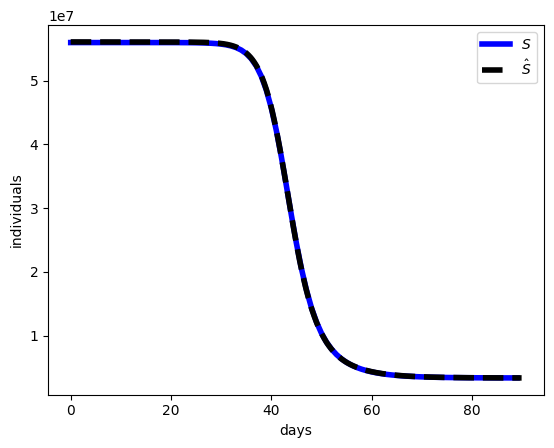

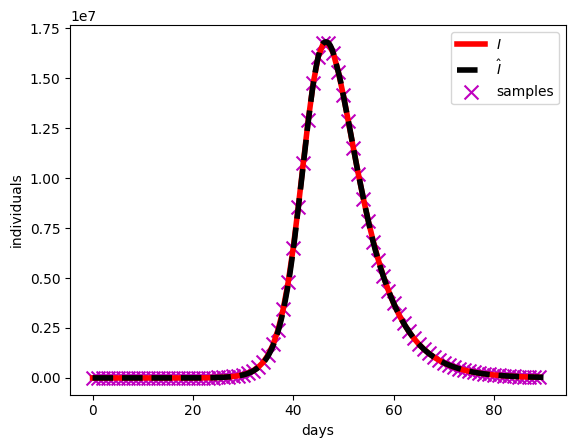

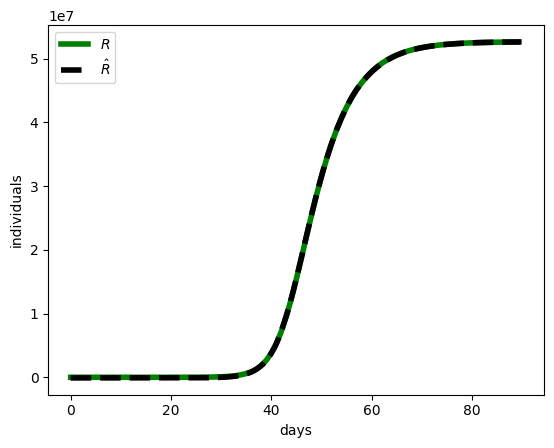

In [14]:
# Get predictions
S_pred_test = Ss.eval(m, t_test_sc)
I_pred_test = Is.eval(m, t_test_sc)
R_pred_test = Rs.eval(m, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$S$', '$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$R$', '$\hat{R}$'])
plt.show()

In [15]:
# Evaluate errors
S_pred = Ss.eval(m, t_data_sc)*C
I_pred = Is.eval(m, t_data_sc)*C
R_pred = Rs.eval(m, t_data_sc)*C
beta_pred = Beta.eval(m, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = abs(beta_pred[0]-beta)/beta

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')

2024-05-19 16:08:41.121428: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_4/Square' id:145 op device:{requested: '', assigned: ''} def:{{{node sci_activation_4/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_4/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:08:41.230373: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_9/Square' id:286 op device:{requested: '', assigned: ''} def:{{{node sci_activation_9/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_9/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:08:41.333803: W tensorflow

Input and output dimensions need re-adjustment for post-processing.
S error: 1.761e-03
I error: 4.696e-03
R error: 1.908e-03
Beta error: 1.332e-03


In [16]:
# Save training history and model
with open('hJoint.txt', 'wb') as myFile:
    pickle.dump(h.history, myFile)
myFile.close()

m.save_weights('mJoint.hdf5')

### Split

In [17]:
sn.reset_session()

In [18]:
# Build NN - Split - only data regression
ts  = sn.Variable('ts')
Isc = sn.Functional('Isc', ts, 4*[50], output_activation='square')

In [19]:
# Build the model - Split - only data regression
loss_data = sn.Data(Isc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [20]:
# Training points - Split - only data regression
if weekly: 
    t_data_train = t_data_sc[::7]
    epochs_data  = 1000
    batch_data   = 13
else: 
    t_data_train = t_data_sc
    epochs_data  = 3000
    batch_data   = 10

In [22]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          I_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=0)
time2_data = time.time()


Total samples: 90 
Batch size: 10 
Total batches: 9 


Epoch 1365: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 1665: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 2910: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


In [23]:
print(f'Training time: {time2_data-time1_data}')

Training time: 304.8161039352417


2024-05-19 16:17:04.511827: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_4/Square' id:145 op device:{requested: '', assigned: ''} def:{{{node sci_activation_4/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_4/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


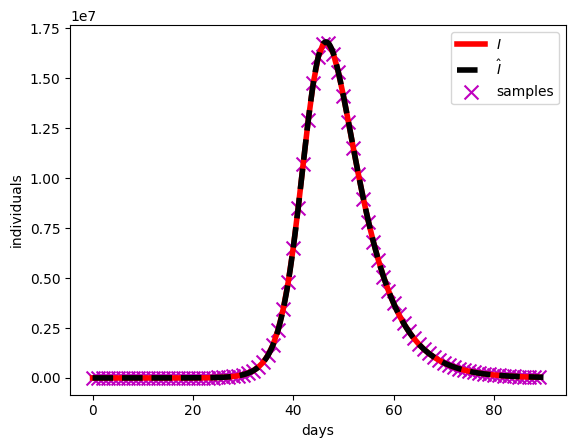

In [24]:
# Get predictions
Isc_pred = Isc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,Isc_pred*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

In [25]:
# Evaluate errors
Isc_pred = Isc.eval(m_data,t_data_sc)
Isc_err = np.linalg.norm(I_data_sc-Isc_pred,2)/np.linalg.norm(I_data_sc,2)
print(f'Isc error: {Isc_err:.3e}')

Isc error: 7.802e-04


2024-05-19 16:17:06.047464: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_4/Square' id:145 op device:{requested: '', assigned: ''} def:{{{node sci_activation_4/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_4/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [27]:
# Fix the I-NN weights
Isc_weights = Isc.get_weights()

Is = sn.Functional('Is', ts, 4*[50], output_activation='square', trainable=False)
Is.set_weights(Isc_weights)

2024-05-19 16:18:17.181090: W tensorflow/c/c_api.cc:291] Operation '{name:'Is_1/bias/Assign' id:869 op device:{requested: '', assigned: ''} def:{{{node Is_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Is_1/bias, Is_1/bias/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [28]:
# Build NN - Split - fully physics-informed
Ss = sn.Functional('Ss', ts, 4*[50], output_activation='square')

Beta = sn.Parameter(name='Beta', inputs=ts, non_neg=True)

Rs = N/C-Is-Ss

In [29]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), 'L_S0')
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), 'L_R0')

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), 'L_dSdt')
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), 'L_dIdt')
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), 'L_dRdt')

In [30]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
            sn.PDE(L_S0), sn.PDE(L_R0), 
            sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Is*0.0)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)


loss_train_ode = ['zeros']*8

epochs_ode = 1000
log_params   = {'parameters': Beta, 'freq':1}

In [32]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train_ode,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        log_parameters=log_params,
                        adaptive_weights=adaptive_NTK,
                        verbose=0)
time2_ode = time.time()


Total samples: 6000 
Batch size: 100 
Total batches: 60 


+ NTK evaluation time [s]: 0.8648388385772705 

+ adaptive_weights at epoch 1: [0.4006894082392219, 0.5061727337753811, 0.8313053349229539, 1.252366505208535, 1.252366505208535, 1.252366505208535, 1.252366505208535, 1.252366505208535]

+ NTK evaluation time [s]: 0.4627525806427002 

+ adaptive_weights at epoch 101: [0.4119323254864511, 0.608036933267732, 0.5071579244370658, 1.2945745669380289, 1.2945745669380289, 1.2945745669380289, 1.2945745669380289, 1.2945745669380289]

+ NTK evaluation time [s]: 0.4922902584075928 

+ adaptive_weights at epoch 201: [0.41257978463124556, 0.6214607935357859, 0.4732417680394423, 1.2985435361231235, 1.2985435361231235, 1.2985435361231235, 1.2985435361231235, 1.2985435361231235]

+ NTK evaluation time [s]: 0.4919464588165283 

+ adaptive_weights at epoch 301: [0.4124169482686848, 0.6255368242364798, 0.46838695284719456, 1.2987318591018533, 1.2987318591018533, 1.2987318591018533, 1.2987318591018

In [33]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 288.7697277069092


2024-05-19 16:33:19.761792: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_19/Square' id:1059 op device:{requested: '', assigned: ''} def:{{{node sci_activation_19/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_19/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:33:19.848745: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_14/Square' id:877 op device:{requested: '', assigned: ''} def:{{{node sci_activation_14/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_14/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:33:19.919905: W ten

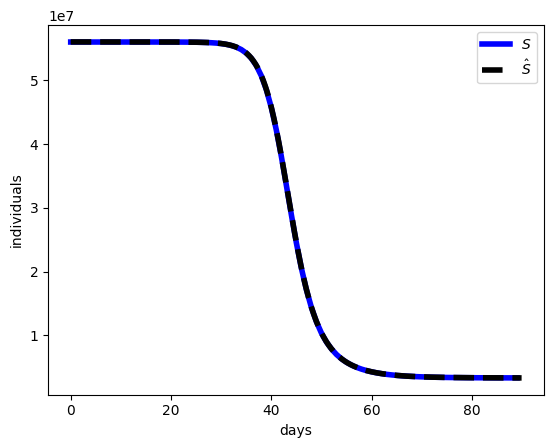

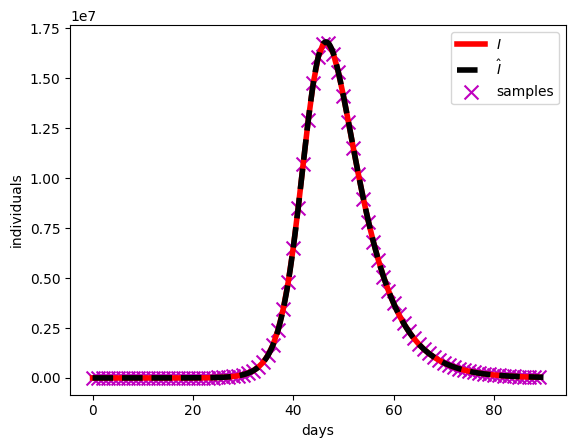

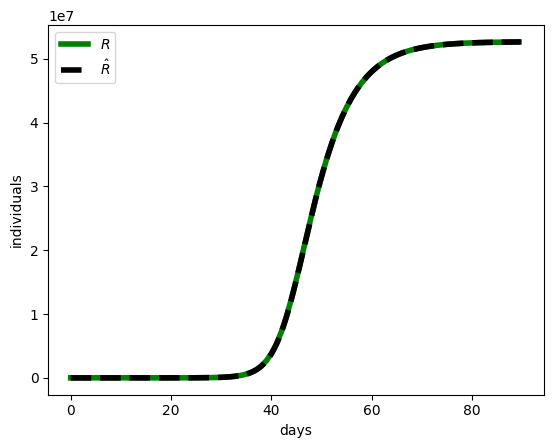

In [34]:
# Get predictions
S_pred_test = Ss.eval(m_ode, t_test_sc)
I_pred_test = Is.eval(m_ode, t_test_sc)
R_pred_test = Rs.eval(m_ode, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$S$', '$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$R$', '$\hat{R}$'])
plt.show()

In [38]:
# Evaluate errors
S_pred = Ss.eval(m_ode, t_data_sc)*C
I_pred = Is.eval(m_ode, t_data_sc)*C
R_pred = Rs.eval(m_ode, t_data_sc)*C
beta_pred = Beta.eval(m_ode, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = abs(beta_pred[0]-beta)/beta

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')

2024-05-19 16:34:58.012826: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_19/Square' id:1059 op device:{requested: '', assigned: ''} def:{{{node sci_activation_19/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_19/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:34:58.106337: W tensorflow/c/c_api.cc:291] Operation '{name:'sci_activation_14/Square' id:877 op device:{requested: '', assigned: ''} def:{{{node sci_activation_14/Square}} = Square[T=DT_FLOAT, _has_manual_control_dependencies=true](sci_activation_14/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-19 16:34:58.175932: W ten

Input and output dimensions need re-adjustment for post-processing.
S error: 6.405e-04
I error: 7.802e-04
R error: 7.368e-04
Beta error: 2.071e-04


In [36]:
# Save training histories and models
with open('hSplit_data.txt', 'wb') as myFile:
    pickle.dump(h_data.history, myFile)
myFile.close()

m_data.save_weights('mSplit_data.hdf5')

with open('hSplit_ode.txt', 'wb') as myFile:
    pickle.dump(h_ode.history, myFile)
myFile.close()

m_ode.save_weights('mSplit_ode.hdf5')

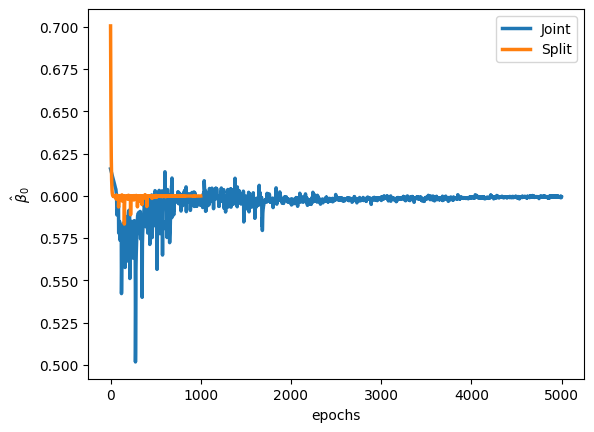

In [37]:
# Beta identification comparison
plt.plot(h.history['Beta'], linewidth=2.5)
plt.plot(h_ode.history['Beta'],linewidth=2.5)
plt.legend(['Joint', 'Split'])
plt.ylabel(r'$\hat{\beta}_0$')
plt.xlabel('epochs')
plt.show()